<a href="https://colab.research.google.com/github/sasso-effe/ADAS-made-trivial/blob/master/syllabification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Google Colab Setup

import sys
import os

%cd /content
!rm -rf Deep-Comedy
!git clone https://github.com/Deep-Poets-Society/Deep-Comedy
%cd Deep-Comedy

sys.path.append(os.getcwd())

!pip install tensorflow
!pip install tensorflow_text

/content
Cloning into 'Deep-Comedy'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (112/112), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 112 (delta 48), reused 86 (delta 29), pack-reused 0
Receiving objects: 100% (112/112), 4.19 MiB | 9.20 MiB/s, done.
Resolving deltas: 100% (48/48), done.
/content/Deep-Comedy
     |████████████████████████████████| 4.3 MB 9.4 MB/s 


In [3]:
from tokenizer import Tokenizer
import tensorflow as tf
import time
import numpy as np
import re
from matplotlib import pyplot as plt
from utils import load_dataset, positional_encoding, loss_function, accuracy_function
from models import Transformer, create_masks
from schedules import CustomSchedule

In [4]:
dataset = load_dataset()
train = dataset['train']
val = dataset['val']

In [5]:
tokenizer = Tokenizer(['[START]', '[END]', 'C', 'S', 'Y'], 'res/vocab.txt')

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [6]:
BUFFER_SIZE = 20000
BATCH_SIZE = 64

In [7]:
def tokenize_pairs(X, y):
    X = tokenizer.tokenize(X)
    # Convert from ragged to dense, padding with zeros.
    X = X.to_tensor()

    y = tokenizer.tokenize(y)
    # Convert from ragged to dense, padding with zeros.
    y = y.to_tensor()

    return X, y


def make_batches(ds):
    return (ds
            .cache()
            .shuffle(BUFFER_SIZE)
            .batch(BATCH_SIZE)
            .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
            .prefetch(tf.data.AUTOTUNE)
            )

In [8]:
train_batches = make_batches(train)
val_batches = make_batches(val)

(1, 2048, 512)


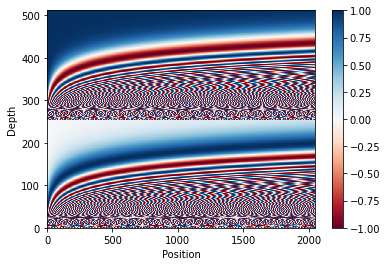

In [9]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]
# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

Set hyperparameters

In [10]:
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

Set Adam optimizer

In [11]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

Loss and metrics

In [12]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

Training and checkpoint

In [13]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizer.get_vocab_size().numpy(),
    target_vocab_size=tokenizer.get_vocab_size().numpy(),
    pe_input=1000,
    pe_target=1000,
    rate=dropout_rate)

In [14]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print('Latest checkpoint restored!!')

In [15]:
EPOCHS = 20

In [16]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [17]:
for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> X, tar -> y
  for (batch, entry) in enumerate(train_batches):
    inp = entry[0]
    tar = entry[1]
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

Epoch 1 Batch 0 Loss 5.9788 Accuracy 0.0013
Epoch 1 Batch 50 Loss 5.2429 Accuracy 0.0894
Epoch 1 Batch 100 Loss 4.5717 Accuracy 0.1812
Epoch 1 Batch 150 Loss 4.2746 Accuracy 0.2151
Epoch 1 Batch 200 Loss 4.0443 Accuracy 0.2458
Epoch 1 Loss 3.9760 Accuracy 0.2551
Time taken for 1 epoch: 25.68 secs

Epoch 2 Batch 0 Loss 3.0049 Accuracy 0.3815
Epoch 2 Batch 50 Loss 2.8812 Accuracy 0.4001
Epoch 2 Batch 100 Loss 2.7749 Accuracy 0.4153
Epoch 2 Batch 150 Loss 2.6958 Accuracy 0.4252
Epoch 2 Batch 200 Loss 2.6266 Accuracy 0.4352
Epoch 2 Loss 2.6076 Accuracy 0.4375
Time taken for 1 epoch: 11.12 secs

Epoch 3 Batch 0 Loss 2.3147 Accuracy 0.4818
Epoch 3 Batch 50 Loss 2.3036 Accuracy 0.4801
Epoch 3 Batch 100 Loss 2.2691 Accuracy 0.4832
Epoch 3 Batch 150 Loss 2.2393 Accuracy 0.4865
Epoch 3 Batch 200 Loss 2.2099 Accuracy 0.4902
Epoch 3 Loss 2.2002 Accuracy 0.4916
Time taken for 1 epoch: 11.18 secs

Epoch 4 Batch 0 Loss 2.0931 Accuracy 0.5070
Epoch 4 Batch 50 Loss 2.0380 Accuracy 0.5141
Epoch 4 Batch 

## Evaluate

In [18]:
def evaluate(line, max_length=100):
  line = tf.convert_to_tensor([line])
  line = tokenizer.tokenize(line).to_tensor()

  encoder_input = line

  start, end = tokenizer.tokenize([''])[0]
  output = tf.convert_to_tensor([start])
  output = tf.expand_dims(output, 0)

  for i in range(max_length):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)

    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer.call((encoder_input, output),
                                                 False)

    # select the last word from the seq_len dimension
    predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.argmax(predictions, axis=-1)

    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

    # return the result if the predicted_id is equal to the end token
    if predicted_id == end:
      break

  # output.shape (1, tokens)
  text = tokenizer.detokenize(output)[0]  # shape: ()

  tokens = tokenizer.lookup(output)[0]

  return text, tokens, attention_weights

In [39]:
def print_prediction(x, true=None, add_spaces=True):
  if true is not None:
    true = re.sub(' ', '', true)
    true = re.sub('S', ' ', true)
    true = re.sub('C', '$', true)
    true = re.sub('Y', '|', true)
  else:
    true = 'Not provided\n'

  if add_spaces:
    x = re.sub(' ', ' S ', x)
  
  predicted, _, _ = evaluate(x)
  x = re.sub('\n', '', x)
  x = re.sub(' S ', ' ', x)
  predicted = predicted.numpy().decode('utf-8')
  print(f'Original:\t{x}')
  print(f'Predicted:\t{predicted}')
  print(f'True:\t\t{true}')

In [40]:
test = dataset['test']
for batch, (x, y) in enumerate(test.batch(1)):
  x = x.numpy()[0].decode('utf-8')
  y = y.numpy()[0].decode('utf-8')
  print_prediction(x, y, add_spaces=False)
  if batch >=9 :
    break


Original:	in voce assai più che la nostra viva
Predicted:	|in |vo|ce as|sai |più |che $la |no|stra |vi|va
True:		|in |vo|ce as|sai |più |che $la |no|stra |vi|va

Original:	ché per etterna legge è stabilito
Predicted:	|ché |per |et|ter|na |leg|ge è $sta|bi|li|to
True:		|ché |per |et|ter|na |leg|ge è $sta|bi|li|to

Original:	che son quinc’ entro se l’ unghia ti basti
Predicted:	|che |son |quin|c’ en|tro |se $l’ un|ghia |ti |ba|sti
True:		|che |son |quin|c’ en|tro |se $l’ un|ghia |ti |ba|sti

Original:	saver fu messo che se ’l vero è vero
Predicted:	|sa|ver |fu |mes|so |che $se ’l |ve|ro è |ve|ro
True:		|sa|ver |fu |mes|so |che $se ’l |ve|ro è |ve|ro

Original:	e sempre di mirar faceasi accesa
Predicted:	|e |sem|pre |di |mi|rar $fa|cea|si ac|ce|sa
True:		|e |sem|pre |di |mi|rar $fa|cea|si ac|ce|sa

Original:	e bëatrice forse maggior cura
Predicted:	|e |bë|a|tri|ce |for|se $mag|gior |cu|ra
True:		|e |bë|a|tri|ce |for|se $mag|gior |cu|ra

Original:	onde cessar le sue opere biece
Predicted:	

In [42]:
infinito = ['sempre caro mi fu quest’ermo colle',
            'e questa siepe che da tanta parte',
            'dell’ultimo orizzonte il guardo esclude',
            'ma sedendo e mirando interminati',
            'spazi di là da quella e sovrumani',
            'silenzi e profondissima quïete',
            'io nel pensier mi fingo ove per poco',
            'il cor non si spaura e come il vento',
            'odo stormir tra queste piante io quello',
            'infinito silenzio a questa voce',
            'vo comparando e mi sovvien l’eterno',
            'e le morte stagioni e la presente',
            'e viva e il suon di lei così tra questa',
            'immensità s’annega il pensier mio',
            'e il naufragar m’è dolce in questo mare']

for line in infinito:
  print_prediction(line)


Original:	sempre caro mi fu quest’ermo colle
Predicted:	|sem|pre |ca|ro |mi |fu $que|strre|mo |col|le
True:		Not provided

Original:	e questa siepe che da tanta parte
Predicted:	|e |que|sta |sie|pe |che $da |tan|ta |par|te
True:		Not provided

Original:	dell’ultimo orizzonte il guardo esclude
Predicted:	|del|l’ ul|ti|mo o|riz|zon|te il $guar|do e|scu|de
True:		Not provided

Original:	ma sedendo e mirando interminati
Predicted:	|ma |se|den|do e $mi|ran|do in|ter|mi|na|ti
True:		Not provided

Original:	spazi di là da quella e sovrumani
Predicted:	|spa|zi |di |là |da |quel|la e $sov|ru|ma|ni
True:		Not provided

Original:	silenzi e profondissima quïete
Predicted:	|si|len|zi e |pro|fon|dis|si|ma $quï|e|te
True:		Not provided

Original:	io nel pensier mi fingo ove per poco
Predicted:	|io |nel |pen|sier $mi |fin|go o|ve |per |po|co
True:		Not provided

Original:	il cor non si spaura e come il vento
Predicted:	|il |cor |non |si |spau|ra e $co|me il |ven|to
True:		Not provided

Original:	odo s

In [45]:
cinque_maggio = ['ei fu siccome immobile',
                'dato il mortal sospiro',
                'stette la spoglia immemore',
                'orba di tanto spiro',
                'così percossa attònita',
                'la terra al nunzio sta',
                'muta pensando all’ultima',
                'ora dell’uom fatale',
                'né sa quando una simile',
                'orma di piè mortale',
                'la sua cruenta polvere'
                'a calpestar verrà']

for line in cinque_maggio:
  print_prediction(line)

Original:	ei fu siccome immobile
Predicted:	|ei |fu |sic|co|me $im|mo|bi|le|le
True:		Not provided

Original:	dato il mortal sospiro
Predicted:	|da|to il |mor|tal $so|spi|ro|ro|ro
True:		Not provided

Original:	stette la spoglia immemore
Predicted:	|stet|te |la |spo|glia $im|me|mo|ro|re
True:		Not provided

Original:	orba di tanto spiro
Predicted:	|or|ba |di |tan|to $spi|ro|ro|ba |di |tan|po
True:		Not provided

Original:	così percossa attònita
Predicted:	|co|sì |per|cos|sa $at|tò|ni|ta|ta
True:		Not provided

Original:	la terra al nunzio sta
Predicted:	|la |ter|ra al |nun|zio |sta $o |ter|ra|ra al |sta
True:		Not provided

Original:	muta pensando all’ultima
Predicted:	|mu|ta |pen|san|do $al|l’ ul|ti|ma
True:		Not provided

Original:	ora dell’uom fatale
Predicted:	|o|ra |del|l’|mo $fa|ta|le|le
True:		Not provided

Original:	né sa quando una simile
Predicted:	|né |sa |quan|do u|na $si|mi|le|le
True:		Not provided

Original:	orma di piè mortale
Predicted:	|or|ma |di |piè $mor|ta|te|le
Tr

In [43]:
mattina = ['m’illumino', 'd’immenso']

for line in mattina:
  print_prediction(line)

Original:	m’illumino
Predicted:	|m’|lu|mu|mi|no
True:		Not provided

Original:	d’immenso
Predicted:	|d’|men|men|so|so
True:		Not provided



In [46]:
 elegia = ['hic ego dux milesque bonus vos signa tubaeque',
          'ite procul cupidis vulnera ferte viris',
          'ferte et opes ego composito securus acervo',
          'dites despiciam despiciamque famem']

for line in elegia:
  print_prediction(line)

Original:	hic ego dux milesque bonus vos signa tubaeque
Predicted:	|hi |e|go |du|poi |mi|le|sque $bon |vos |cian|ba
True:		Not provided

Original:	ite procul cupidis vulnera ferte viris
Predicted:	|it|te |pro|cul |cu|di|si $vul|ne|rar|te |vi|se
True:		Not provided

Original:	ferte et opes ego composito securus acervo
Predicted:	|fer|te et|te o|sgo e|go $com|so|to |se|cu|ser
True:		Not provided

Original:	dites despiciam despiciamque famem
Predicted:	|di|tes |de|spic|cia $de|spic|cia|que |fa|me
True:		Not provided



In [49]:
print_prediction('a')

Original:	a
Predicted:	|a|o|zo|o|o|a|aa|a|a|a|a|a|aaaaaaaaa|aaaaaa|aa|a|a|aaaa|a|a|a|a|a|a|a|a|a|a|a|a|a|a|a|a|a|a|a|a|a|a|
True:		Not provided

